In [1]:
from math import pi
from copy import deepcopy
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator

ModuleNotFoundError: No module named 'qiskit_ibm_runtime'

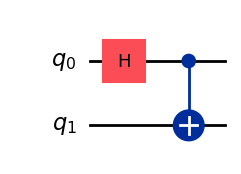

In [ ]:
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

For individual measurements, each qubit has its own measurement operator. 
If the system consists of two qubits (following Qiskit's convention, where the leftmost index corresponds to qubit 1 and the rightmost index corresponds to qubit 0):

- To measure qubit 1 separately, the operator is:
  $$
  Z \otimes I
  $$
  (where $Z$ acts on qubit 1 and $I$ acts on qubit 0)

- To measure qubit 0 separately, the operator is:
  $$
  I \otimes Z
  $$
  (where $I$ acts on qubit 1 and $Z$ acts on qubit 0)

For joint measurement (to obtain the correlation between the two qubits), the operator is the tensor product of these individual measurements:
$$
Z \otimes Z
$$
This is often written as $ ZZ $, representing the simultaneous measurement of $Z$ on qubit 1 and qubit 0, with the result indicating their correlation.

$ ZZ $ is shorthand for $ Z \otimes Z $, which measures $ Z $ on qubit 1 and qubit 2, obtaining the correlation between qubit 1 and qubit 2.

If the state is entangled, the expectation value of $ \langle Z_1 Z_0 \rangle $ should be 1.


In [ ]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]
print(observables)

[SparsePauliOp(['IZ'],
              coeffs=[1.+0.j]), SparsePauliOp(['IX'],
              coeffs=[1.+0.j]), SparsePauliOp(['ZI'],
              coeffs=[1.+0.j]), SparsePauliOp(['XI'],
              coeffs=[1.+0.j]), SparsePauliOp(['ZZ'],
              coeffs=[1.+0.j]), SparsePauliOp(['XX'],
              coeffs=[1.+0.j])]


In [ ]:
# token = "1e3d751314af74e1e0159c5627fd58fa0aae02f35f4ea1e6fd1b473861787194163dec9efc673d38ff345e7c2472f851009cff352fd0e3787a427163a951c9fe"

# from qiskit_ibm_runtime import QiskitRuntimeService
 
# QiskitRuntimeService.save_account(
#   token=token,
#   channel="ibm_quantum" # `channel` distinguishes between different account types
# )


We have the quantum circuit defined already, we can apply what ever gate we want on the circuit, but a real quantum computer has its own limitations, so 'generate_preset_pass_manager' is a predecure that convert our designed circuit to the gates actually supported by the quantum computer. The re-designed circuit should be as shallow as possible with least number of gates to reduce error. The recompile circuit is equivalent to the initially designed circuit.

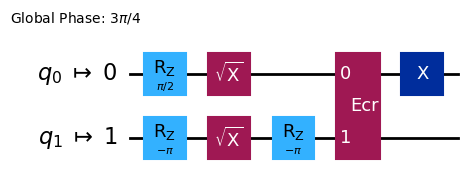

In [ ]:
service = QiskitRuntimeService()

# find a least busy and currently working quantum computer to be our target backend
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

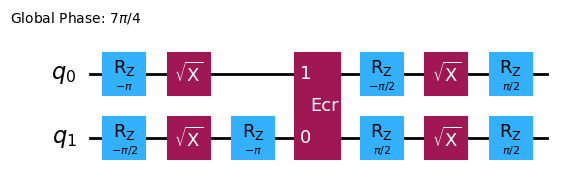

In [ ]:
# Change q[127] to q[2], as only 2 qubits are needed
qasm = r"""
OPENQASM 2.0;
include "qelib1.inc";

// Define custom gates rzx and ecr
gate rzx(param0) q0,q1 {
    h q1;
    cx q0,q1;
    rz(param0) q1;
    cx q0,q1;
    h q1;
}

gate ecr q0,q1 {
    rzx(pi/4) q0,q1;
    x q0;
    rzx(-pi/4) q0,q1;
}

// Use only 2 qubits: qreg q[2];
qreg q[2];

// The following is a series of operations on q[0], q[1]:
rz(-pi) q[0];
sx q[0];
rz(-pi/2) q[1];
sx q[1];
rz(-pi) q[1];
ecr q[1],q[0];
rz(-pi/2) q[0];
sx q[0];
rz(pi/2) q[0];
rz(pi/2) q[1];
sx q[1];
rz(pi/2) q[1];
"""

# 1. Create a QuantumCircuit from the QASM string
circuit = QuantumCircuit.from_qasm_str(qasm)
circuit.global_phase = 7 * pi / 4

# 2. Visualize in Jupyter Notebook
# %matplotlib inline
circuit.draw("mpl")


Circuit without measurement:


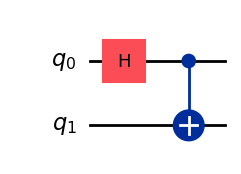

Circuit with measurement on all qubits:


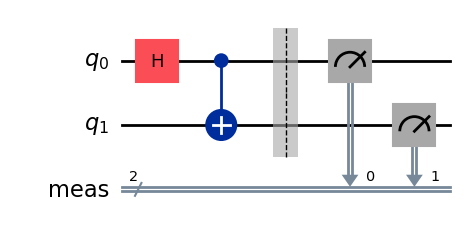

In [ ]:
# 1. Construct a sample circuit (you can replace it with your own circuit)
qc_original = QuantumCircuit(2, name="original")
qc_original.h(0)
qc_original.cx(0, 1)

# 2. Draw the circuit before adding measurement
print("Circuit without measurement:")
display(qc_original.draw("mpl"))  # Use display for visualization in Jupyter Notebook

# 3. Deep copy the circuit and add measurement gates to the copy
qc_with_m = deepcopy(qc_original)
qc_with_m.measure_all()

# 4. Draw the circuit after adding measurement
print("Circuit with measurement on all qubits:")
display(qc_with_m.draw("mpl"))

# quantum measurement is unrevertable operations, after q0 and q1 are measured, they are converted into classical information

In [ ]:
def run_with_statevector(circ_in, name):
    """Measure the given circuit circ_in and execute with statevector_simulator for 1000 shots, output the result."""
    
    # 1. Copy the circuit and add measurement to all qubits
    circ_meas = deepcopy(circ_in)
    circ_meas.measure_all()

    # 2. Use local simulator with method='statevector'
    sim_backend = AerSimulator(method='statevector')

    # 3. Transpile the circuit, then execute
    transpiled_circ = transpile(circ_meas, sim_backend)
    job = sim_backend.run(transpiled_circ, shots=5000)
    result = job.result()
    counts = result.get_counts(transpiled_circ)

    # 4. Print the measurement result distribution
    print(f"Counts for {name}:")
    print(counts)
    print("")

# Execute both circuits
run_with_statevector(qc, "qc")
run_with_statevector(circuit, "circuit")

Counts for qc:
{'00': 2497, '11': 2503}

Counts for circuit:
{'11': 2476, '00': 2524}



In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

# 初始化服务（确保账户已经登录）
service = QiskitRuntimeService()

# 用 job_id 检索作业（例如：cywbs0cy2gd00088f1vg）
job_id = "cywbs0cy2gd00088f1vg"
job = service.job(job_id)

# 如果作业未结束，可以等待作业完成
job.wait_for_final_state()

# 获取作业结果并打印
result = job.result()
print(f">>> Job ID: {job.job_id()}")
print("作业结果:")
print(result)


>>> Job ID: cywbs0cy2gd00088f1vg
作业结果:
PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})


In [ ]:
# 假设 result 是 job.result() 得到的 PrimitiveResult 对象
print("外层 metadata:")
print(result.metadata)

# 通过下标访问第一个 PubResult 对象
pub = result[0]

print("\nPubResult 的 data:")
print("evs:", pub.data.evs)
print("stds:", pub.data.stds)
print("ensemble_standard_error:", pub.data.ensemble_standard_error)
print("shape:", pub.data.shape)

print("\nPubResult 内部的 metadata:")
print(pub.metadata)


外层 metadata:
{'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2}

PubResult 的 data:
evs: [-0.03808993 -0.01053551 -0.03993062 -0.00307159  0.999283    1.03046883]
stds: [0.01364567 0.01470471 0.01427334 0.01664239 0.01280302 0.01257671]
ensemble_standard_error: [0.01435158 0.01436005 0.01554622 0.01555101 0.01317645 0.01299314]
shape: (6,)

PubResult 内部的 metadata:
{'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}
